In [1]:
import numpy as np  
import pandas as pd 
import os
import torch 
from torch import nn
import torch.nn.functional as F
import torchvision
import tqdm 
from torchvision.transforms import v2



In [2]:
root = "data\mnist_data"
if not os.path.exists(root):
  os.makedirs(root)

In [3]:
import matplotlib.pyplot as plt

def show_images(images:list[torch.Tensor], nrows:int) -> None:
    if len(images) % nrows != 0:
        raise Exception("not enough images to construct grid")

    for i in range(len(images)):
        im = images[i]
        if len(im.shape)==2:
            images[i] = im.unsqueeze(dim=0)

    grid = torchvision.utils.make_grid(images, nrows, padding=1).permute(1,2,0)
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

In [4]:
def get_loaders(dataset, root, transform, batch_size):
    train_dataset = dataset(root, train=True, transform=transform, download=True)
    val_dataset = dataset(root, train=False, transform=transform, download=True)
    
    train_loader=torch.utils.data.DataLoader(
        train_dataset, batch_size, num_workers=os.cpu_count(), shuffle=True)
    val_loader=torch.utils.data.DataLoader(
        val_dataset, batch_size, num_workers=os.cpu_count(), shuffle=False)
    return train_loader, val_loader


def train_step(train_loader, model, optimizer, loss_fn, device):
    model.to(device), model.train()
    train_loss, avg_kl_div, avg_reconstruction_loss = 0, 0, 0

    for X,Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        outputs = model(X) # outputs -> (reconstructions, mu, log_vars)
        kl_div, reconstruction_loss = loss_fn(outputs , X)
        loss = kl_div + reconstruction_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        avg_kl_div += kl_div.item()
        avg_reconstruction_loss += reconstruction_loss.item()

    train_loss /= len(train_loader)
    avg_kl_div /= len(train_loader)
    avg_reconstruction_loss /= len(train_loader)
    
    print(f"\nTrain loss: {train_loss:.5f} |  kl_div: {avg_kl_div:.5f} | reconstruction_loss: {avg_reconstruction_loss}%\n", flush=True)
    return train_loss

def test_step(test_loader, model, loss_fn, device):
    model.to(device), model.eval()
    test_loss, avg_kl_div, avg_reconstruction_loss = 0, 0, 0

    with torch.inference_mode():
        for X,Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = model(X) # outputs -> (reconstructions, mu, log_vars)
            kl_div, reconstruction_loss = loss_fn(outputs , X)
            loss = kl_div + reconstruction_loss
            test_loss += loss.item()
            avg_kl_div += kl_div.item()
            avg_reconstruction_loss += reconstruction_loss.item()

    test_loss /= len(test_loader)
    avg_kl_div /= len(test_loader)
    avg_reconstruction_loss /= len(test_loader)
    print(f"Test loss: {test_loss:.5f} | kl_div: {avg_kl_div:.5f} | reconstruction_loss: {avg_reconstruction_loss}%\n", flush=True)
    return test_loss

def train(train_loader, val_loader, epochs, optimizer, model, loss_fn, weight_scheduler, device):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in tqdm.trange(epochs):
        weight = weight_scheduler(epoch+1)
        loss_fn.set_weights(weight)
        train_loss = train_step(train_loader, model, optimizer, loss_fn, device)
        val_loss = test_step(val_loader, model, loss_fn ,device)
        train_losses.append(train_loss), val_losses.append(val_loss)

        for loader in [train_loader, val_loader]:
            with torch.inference_mode():
                X, _ = next(iter(loader))
                X = X[:4].to(device)
                reconstructed_ims = model(X)[0][:, 0]
                concat_ims = torch.concat([X, reconstructed_ims], dim=0)
                show_images(concat_ims.cpu(), nrows=4)
                
    return train_losses, val_losses

In [8]:
class ELBOLoss():
    def __init__(self, weight:tuple = (1, 1)):
        self._weight = weight

    def set_weights(self, weight:tuple):
        self._weight = weight
    
    def __call__(self, outputs:tuple, y:torch.Tensor) -> list[torch.Tensor]:
        batch_size = len(y)
        y_preds, mu, log_vars = outputs
        num_samples = y_preds.shape[1]
        kl_div = self._weight[1] * torch.sum(mu*mu + torch.exp(log_vars) - log_vars - 1) / (2 * batch_size)
        y = y.unsqueeze(dim=1).repeat(1, num_samples, 1, 1, 1)
        reconstruction_loss = self._weight[0] * F.binary_cross_entropy(y_preds, y, reduction="sum")/(batch_size*num_samples)
        return kl_div, reconstruction_loss
        

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dim:int, input_dim:int, num_samples:int=1) -> None:
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_samples = num_samples
        self.encoder = nn.Sequential(
                                    nn.Linear(input_dim, 512), 
                                    nn.SiLU(),
                                    nn.Linear(512, 256),
                                    nn.SiLU(),
                                    nn.Linear(256, 64),
                                    nn.SiLU(),
                                    )
        self.mu = nn.Linear(64, latent_dim)
        self.log_var = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
                                    nn.Linear(latent_dim, 64), 
                                    nn.SiLU(),
                                    nn.Linear(64, 256),
                                    nn.SiLU(),
                                    nn.Linear(256, 512),
                                    nn.SiLU(),
                                    )
        self.output_layer = nn.Sequential(nn.Linear(512, input_dim), nn.Sigmoid())

    def encode(self, x:torch.Tensor) -> (torch.Tensor, torch.Tensor):
        features = self.encoder(x)
        mu = self.mu(features)
        log_vars = self.log_var(features)
        return mu, log_vars
        
    def reparameterize(self, mu:torch.Tensor, log_vars:torch.Tensor) -> torch.Tensor:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        B, N = mu.shape
        eps = torch.randn(B, self.num_samples, N, requires_grad=False).to(device)
        std = torch.exp(log_vars*0.5)
        z = mu + (eps@torch.diag_embed(std)).view(self.num_samples, B, N)
        return z 

    def decode(self, z:torch.Tensor) -> torch.Tensor:
        features = self.decoder(z)
        outputs = self.output_layer(features)
        return outputs
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        x = x.reshape(B, -1)
        mu, log_vars = self.encode(x)
        z = self.reparameterize(mu, log_vars)
        preds = self.decode(z).reshape(B, self.num_samples, C, H, W)
        
        return preds, mu, log_vars 

In [10]:
transforms = v2.Compose([
                        v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True),
                        # v2.Normalize(mean=[0.1307], std=[0.3081])
                       ])

In [11]:
BATCH_SIZE = 128
train_loader, val_loader = get_loaders(torchvision.datasets.MNIST, root, transforms, BATCH_SIZE)

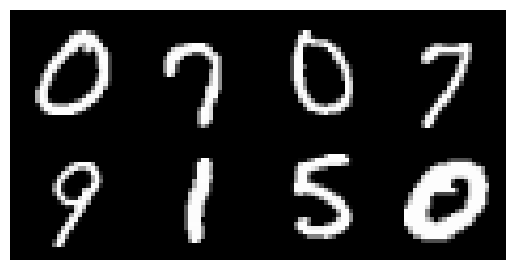

In [12]:
X, _ = next(iter(train_loader))
N = 8
images = list(X[:N])
show_images(images, nrows=4)

In [24]:
latent_dim = 32
input_dim = 28*28 

model = VAE(latent_dim, input_dim, num_samples=1)
num_params = sum([param.numel() for param in model.parameters()])
num_params

1106384

In [25]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       401,920
│    └─SiLU: 2-2                         --
│    └─Linear: 2-3                       131,328
│    └─SiLU: 2-4                         --
│    └─Linear: 2-5                       16,448
│    └─SiLU: 2-6                         --
├─Linear: 1-2                            2,080
├─Linear: 1-3                            2,080
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       2,112
│    └─SiLU: 2-8                         --
│    └─Linear: 2-9                       16,640
│    └─SiLU: 2-10                        --
│    └─Linear: 2-11                      131,584
│    └─SiLU: 2-12                        --
├─Sequential: 1-5                        --
│    └─Linear: 2-13                      402,192
│    └─Sigmoid: 2-14                     --
Total params: 1,106,384
Trainable 

  0%|          | 0/50 [00:00<?, ?it/s]


Train loss: 189.22325 |  kl_div: 6.66082 | reconstruction_loss: 182.562428879077%

Test loss: 169.56128 | kl_div: 9.77765 | reconstruction_loss: 159.78362592866148%



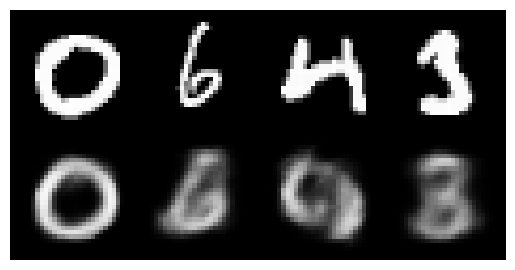

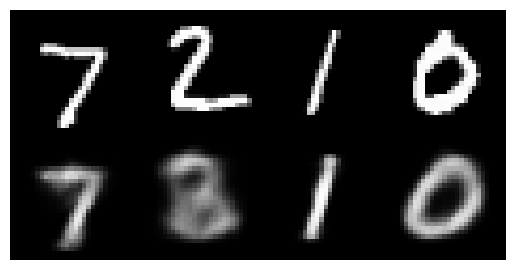

  2%|▏         | 1/50 [00:16<13:04, 16.02s/it]


Train loss: 161.05831 |  kl_div: 12.52418 | reconstruction_loss: 148.53413475703584%

Test loss: 153.25214 | kl_div: 14.27743 | reconstruction_loss: 138.974713289285%



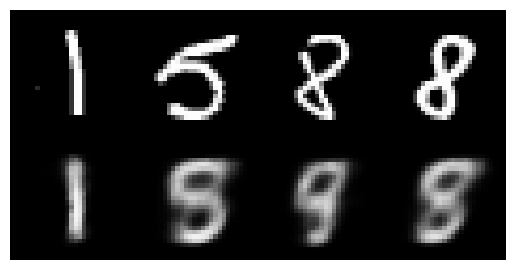

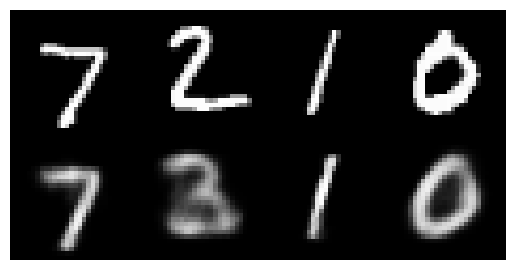

  4%|▍         | 2/50 [00:32<13:09, 16.44s/it]


Train loss: 151.71215 |  kl_div: 14.94182 | reconstruction_loss: 136.7703294245673%

Test loss: 150.36352 | kl_div: 15.65440 | reconstruction_loss: 134.70911813084084%



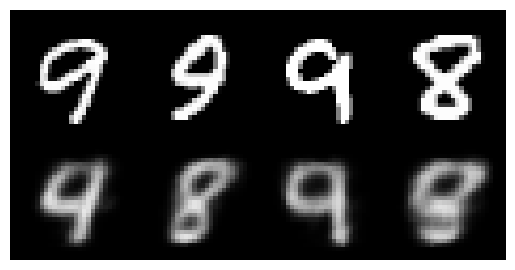

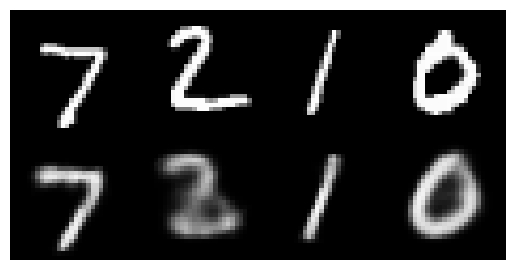

  6%|▌         | 3/50 [00:48<12:48, 16.34s/it]


Train loss: 148.86710 |  kl_div: 15.56055 | reconstruction_loss: 133.30654638815028%

Test loss: 148.56275 | kl_div: 15.68931 | reconstruction_loss: 132.87343858163567%



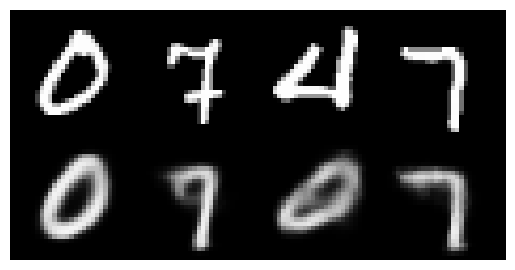

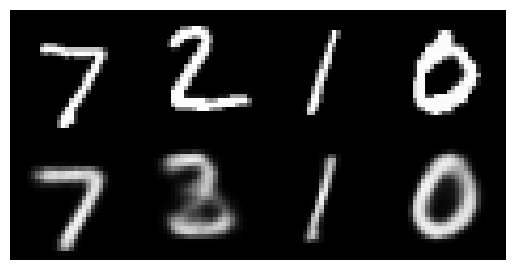

  8%|▊         | 4/50 [01:06<12:57, 16.90s/it]


Train loss: 147.30168 |  kl_div: 15.91782 | reconstruction_loss: 131.38386690184507%

Test loss: 147.03422 | kl_div: 15.75084 | reconstruction_loss: 131.28338140173804%



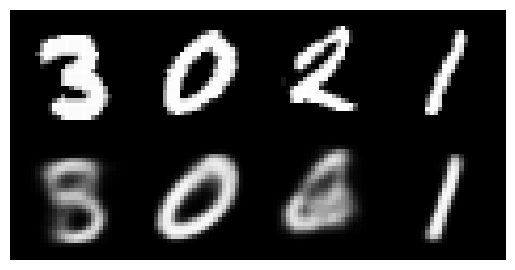

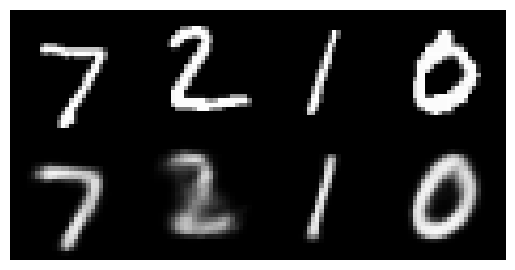

 10%|█         | 5/50 [01:23<12:36, 16.82s/it]


Train loss: 146.18937 |  kl_div: 16.20339 | reconstruction_loss: 129.9859817602487%

Test loss: 146.12312 | kl_div: 16.18126 | reconstruction_loss: 129.94185918494117%



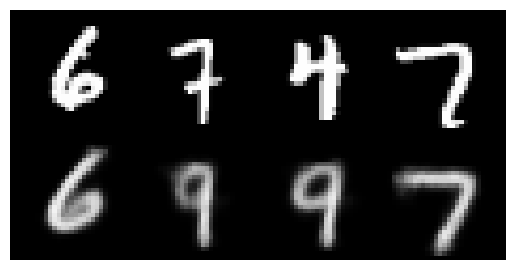

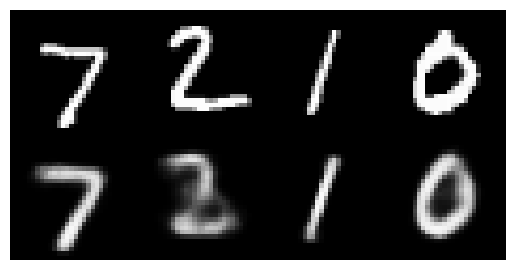

 12%|█▏        | 6/50 [01:40<12:28, 17.01s/it]


Train loss: 145.24223 |  kl_div: 16.37110 | reconstruction_loss: 128.8711238120919%

Test loss: 145.98391 | kl_div: 16.48367 | reconstruction_loss: 129.50023699410355%



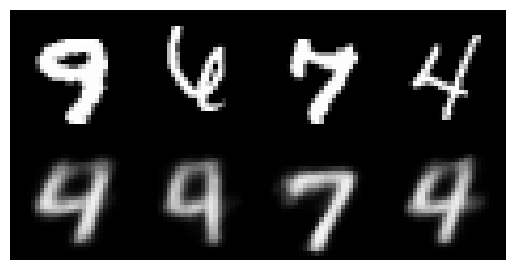

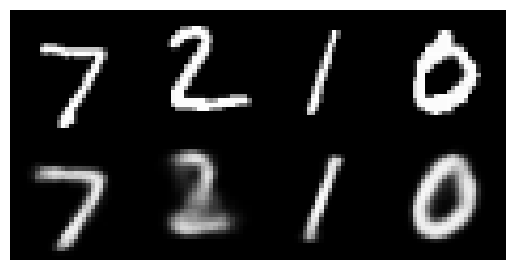

 14%|█▍        | 7/50 [01:58<12:21, 17.24s/it]


Train loss: 144.64944 |  kl_div: 16.52640 | reconstruction_loss: 128.12303735859103%

Test loss: 144.29904 | kl_div: 16.33459 | reconstruction_loss: 127.96444711805898%



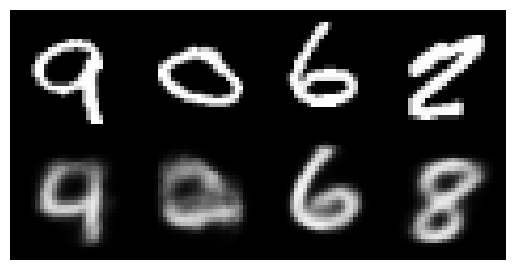

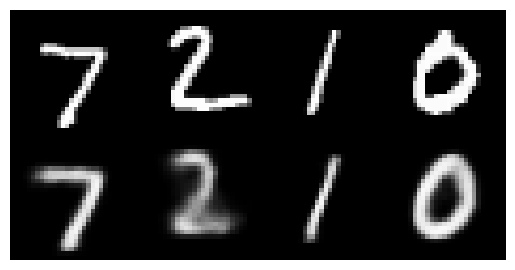

 16%|█▌        | 8/50 [02:16<12:09, 17.37s/it]


Train loss: 144.01837 |  kl_div: 16.67698 | reconstruction_loss: 127.34139274483296%

Test loss: 144.53387 | kl_div: 16.53468 | reconstruction_loss: 127.99918075754672%



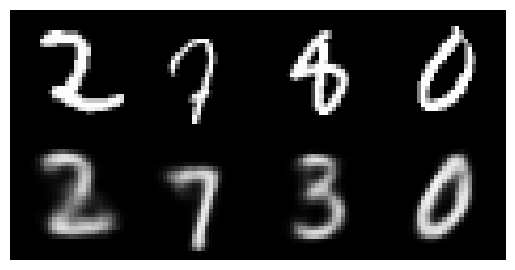

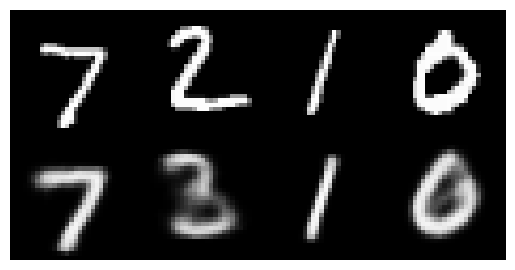

 18%|█▊        | 9/50 [02:32<11:44, 17.18s/it]


Train loss: 143.88756 |  kl_div: 16.76802 | reconstruction_loss: 127.11954451115655%

Test loss: 146.45339 | kl_div: 16.85313 | reconstruction_loss: 129.60026617895198%



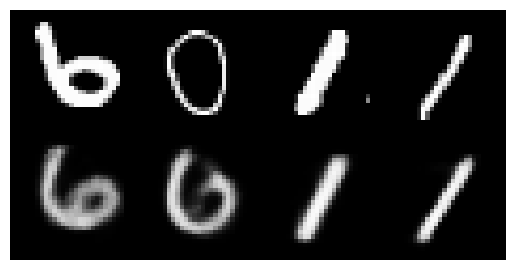

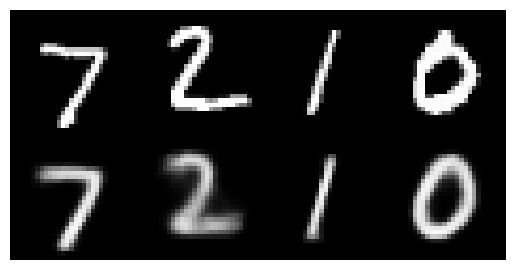

 20%|██        | 10/50 [02:50<11:32, 17.32s/it]


Train loss: 143.42496 |  kl_div: 16.86802 | reconstruction_loss: 126.5569384641993%

Test loss: 143.92312 | kl_div: 16.89726 | reconstruction_loss: 127.02586789674396%



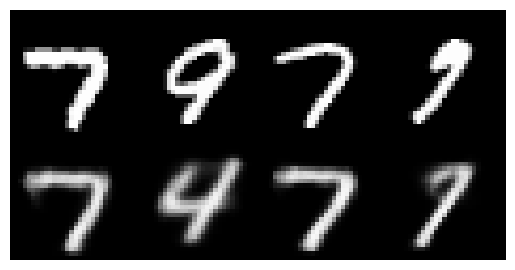

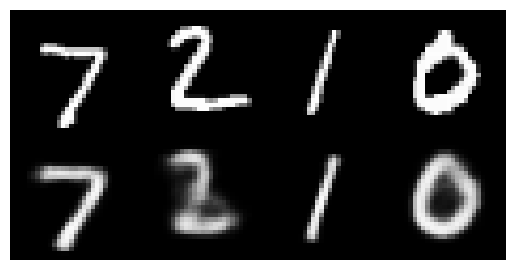

 22%|██▏       | 11/50 [03:07<11:12, 17.24s/it]


Train loss: 142.87551 |  kl_div: 16.96710 | reconstruction_loss: 125.90841489356718%

Test loss: 143.33114 | kl_div: 16.93443 | reconstruction_loss: 126.39670311650143%



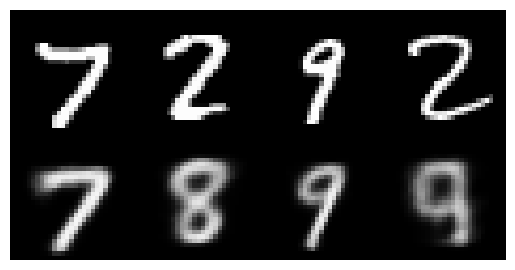

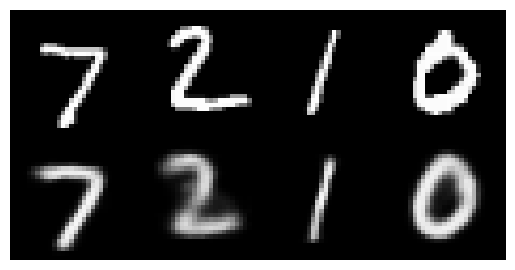

 24%|██▍       | 12/50 [03:24<10:54, 17.24s/it]


Train loss: 142.78916 |  kl_div: 17.05361 | reconstruction_loss: 125.73554387529776%

Test loss: 143.78528 | kl_div: 16.79589 | reconstruction_loss: 126.98939098889315%



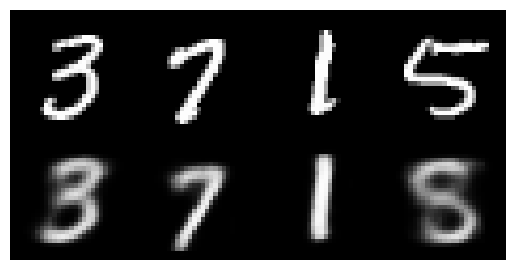

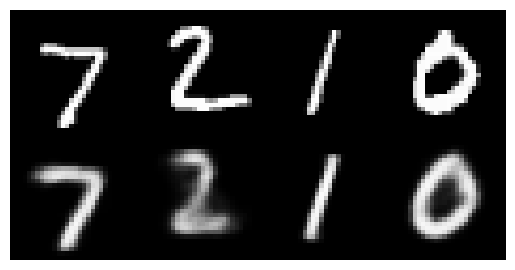

 26%|██▌       | 13/50 [03:41<10:31, 17.07s/it]


Train loss: 142.64759 |  kl_div: 17.05665 | reconstruction_loss: 125.59094291963557%

Test loss: 143.03350 | kl_div: 16.96795 | reconstruction_loss: 126.06554519073873%



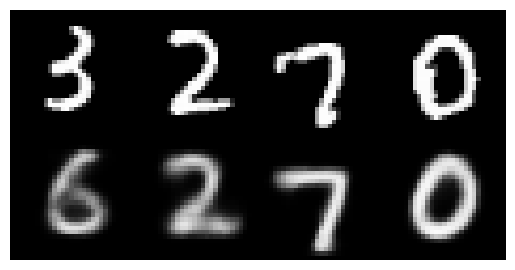

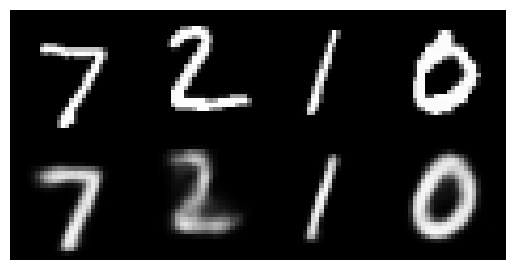

 28%|██▊       | 14/50 [03:59<10:21, 17.27s/it]


Train loss: 142.14018 |  kl_div: 17.14898 | reconstruction_loss: 124.99120182777519%

Test loss: 142.55098 | kl_div: 16.78077 | reconstruction_loss: 125.7702023469949%



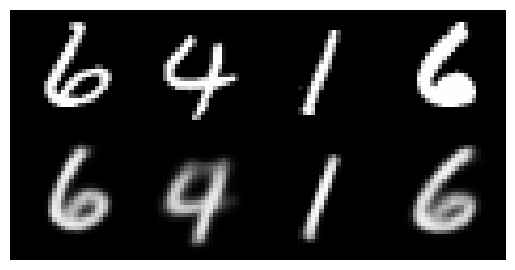

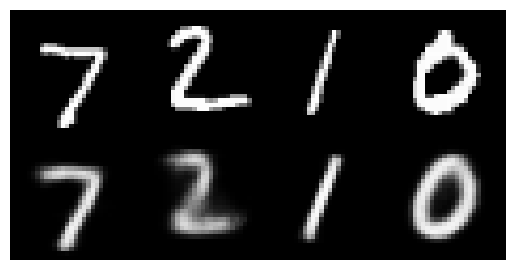

 30%|███       | 15/50 [04:16<10:02, 17.20s/it]


Train loss: 142.19759 |  kl_div: 17.17972 | reconstruction_loss: 125.01786978260031%

Test loss: 143.00506 | kl_div: 16.92585 | reconstruction_loss: 126.0792102089411%



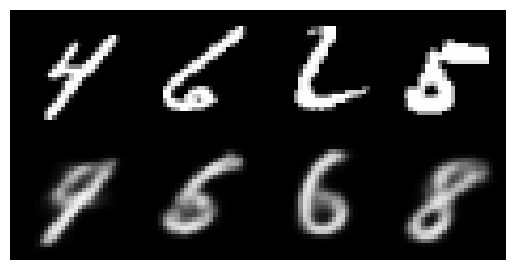

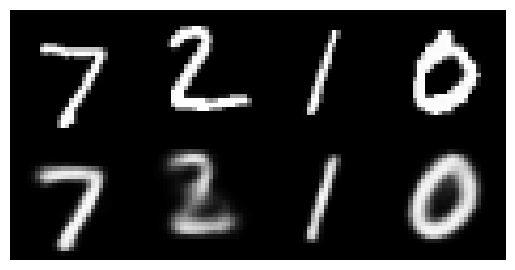

 32%|███▏      | 16/50 [04:32<09:37, 16.97s/it]


Train loss: 141.96474 |  kl_div: 17.22154 | reconstruction_loss: 124.74319471021705%

Test loss: 142.69563 | kl_div: 17.10953 | reconstruction_loss: 125.58610051794898%



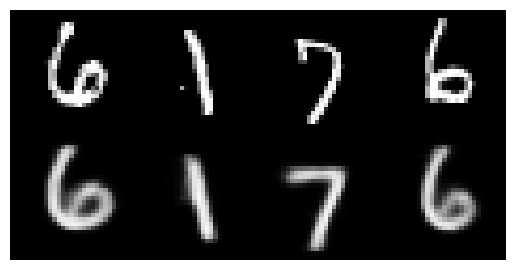

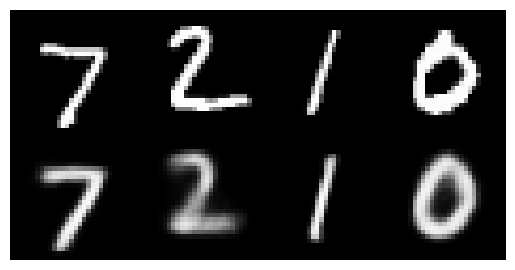

 34%|███▍      | 17/50 [04:49<09:17, 16.89s/it]


Train loss: 141.66721 |  kl_div: 17.28674 | reconstruction_loss: 124.38047302506372%

Test loss: 142.88861 | kl_div: 17.01325 | reconstruction_loss: 125.87536109248295%



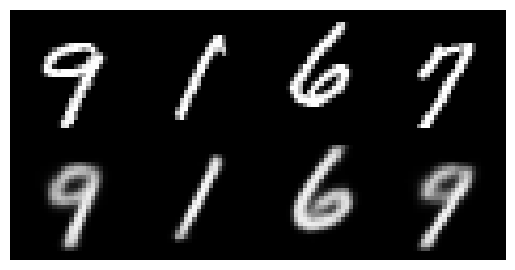

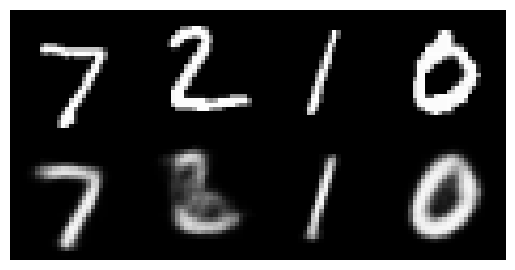

 36%|███▌      | 18/50 [05:05<08:56, 16.76s/it]


Train loss: 141.61148 |  kl_div: 17.33689 | reconstruction_loss: 124.27459295472103%

Test loss: 142.49767 | kl_div: 17.28998 | reconstruction_loss: 125.20769336555577%



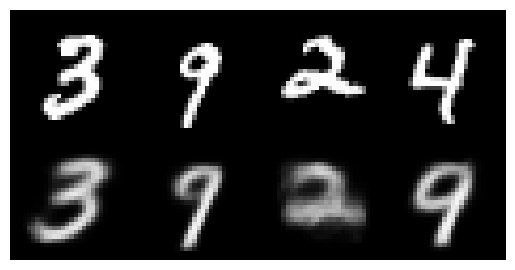

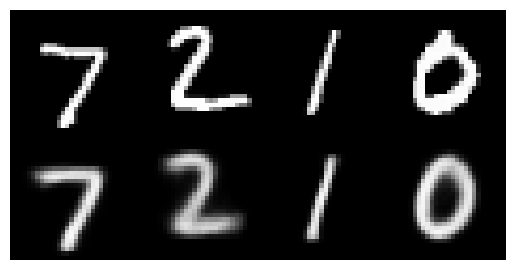

 38%|███▊      | 19/50 [05:22<08:41, 16.83s/it]


Train loss: 141.51574 |  kl_div: 17.36768 | reconstruction_loss: 124.14805788475313%

Test loss: 142.09075 | kl_div: 17.07914 | reconstruction_loss: 125.01160005979901%



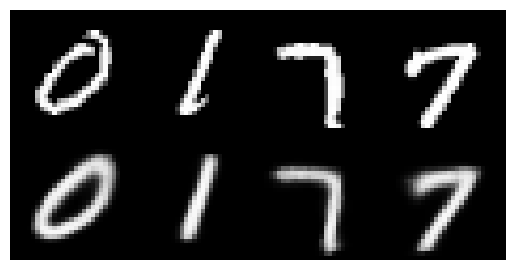

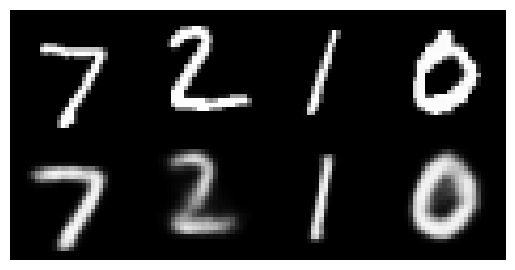

 40%|████      | 20/50 [05:39<08:22, 16.74s/it]


Train loss: 141.56235 |  kl_div: 17.38250 | reconstruction_loss: 124.17985142624454%

Test loss: 143.96674 | kl_div: 17.43308 | reconstruction_loss: 126.53365944005266%



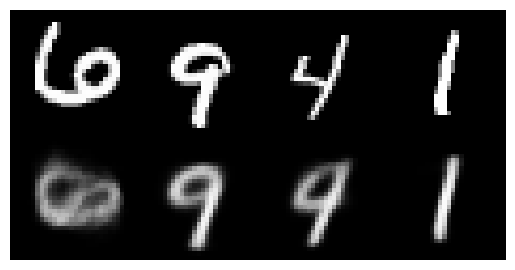

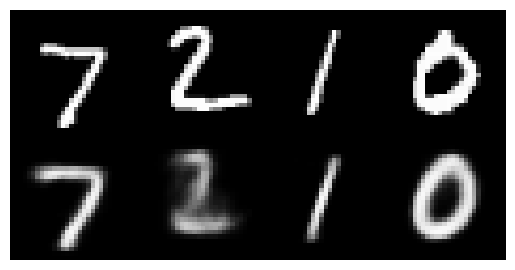

 42%|████▏     | 21/50 [05:56<08:11, 16.94s/it]


Train loss: 141.87583 |  kl_div: 17.38926 | reconstruction_loss: 124.48657586071283%

Test loss: 141.56489 | kl_div: 17.27187 | reconstruction_loss: 124.29302592217168%



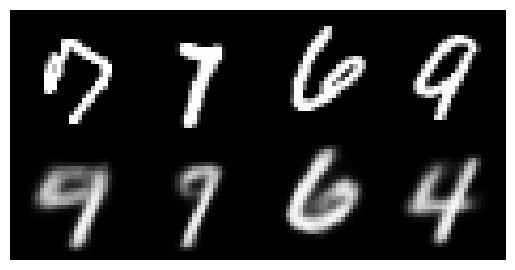

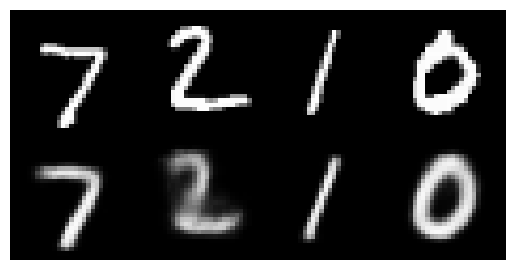

 44%|████▍     | 22/50 [06:13<07:52, 16.86s/it]


Train loss: 141.11431 |  kl_div: 17.48703 | reconstruction_loss: 123.62727970863456%

Test loss: 141.63797 | kl_div: 17.44192 | reconstruction_loss: 124.19604926773265%



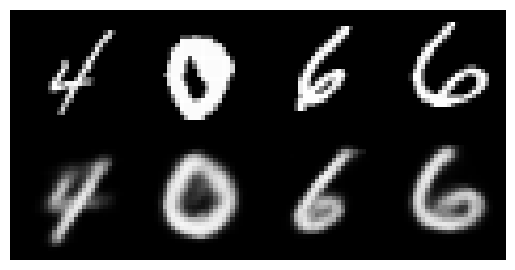

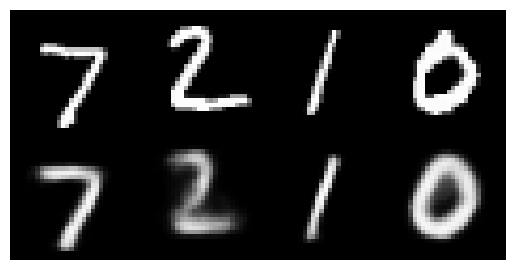

 46%|████▌     | 23/50 [06:30<07:39, 17.00s/it]


Train loss: 140.96028 |  kl_div: 17.47978 | reconstruction_loss: 123.48050317174591%

Test loss: 141.40501 | kl_div: 17.35296 | reconstruction_loss: 124.05204879181295%



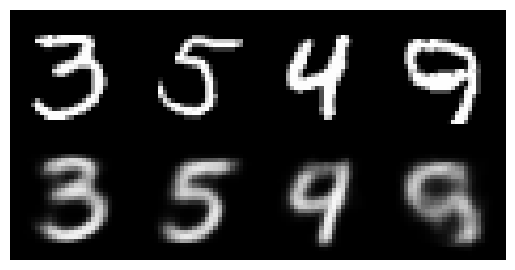

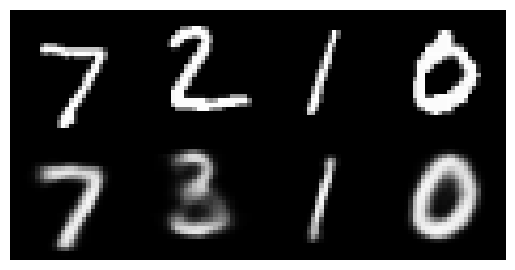

 48%|████▊     | 24/50 [06:47<07:18, 16.88s/it]


Train loss: 140.89766 |  kl_div: 17.49214 | reconstruction_loss: 123.40552192151165%

Test loss: 141.61390 | kl_div: 17.33798 | reconstruction_loss: 124.27591714979727%



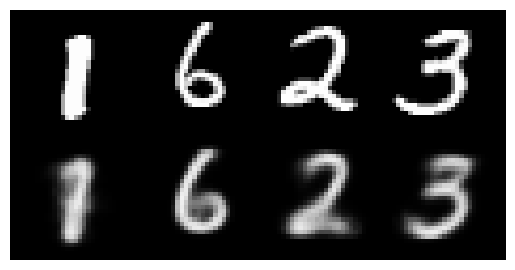

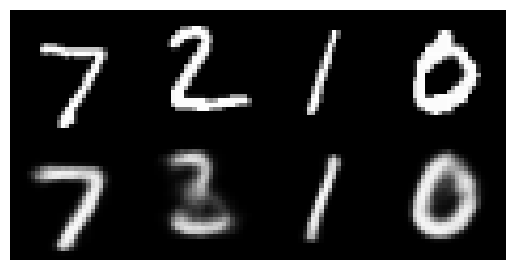

 50%|█████     | 25/50 [07:04<07:06, 17.07s/it]


Train loss: 140.88970 |  kl_div: 17.52997 | reconstruction_loss: 123.35972941709734%

Test loss: 141.58039 | kl_div: 17.72880 | reconstruction_loss: 123.85158509845975%



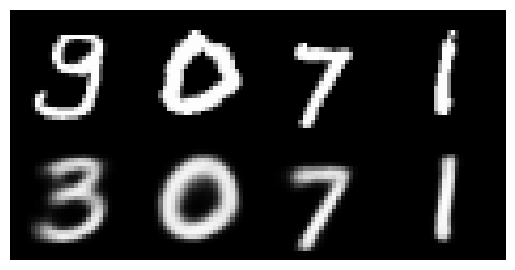

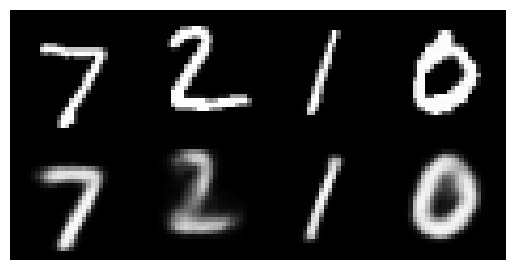

 52%|█████▏    | 26/50 [07:21<06:45, 16.91s/it]


Train loss: 140.67759 |  kl_div: 17.56370 | reconstruction_loss: 123.1138904628469%

Test loss: 141.54254 | kl_div: 17.35567 | reconstruction_loss: 124.1868740999246%



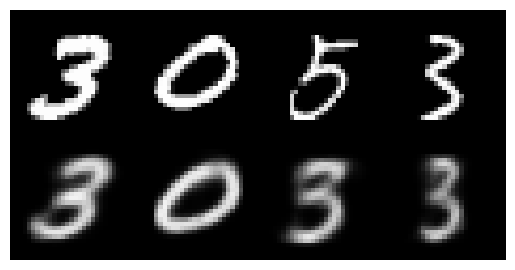

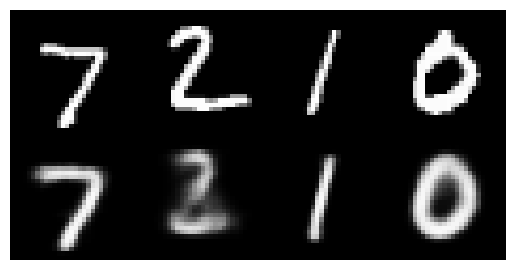

 54%|█████▍    | 27/50 [07:38<06:31, 17.03s/it]


Train loss: 140.44622 |  kl_div: 17.57630 | reconstruction_loss: 122.86991983181886%

Test loss: 141.40066 | kl_div: 17.27778 | reconstruction_loss: 124.12288443649871%



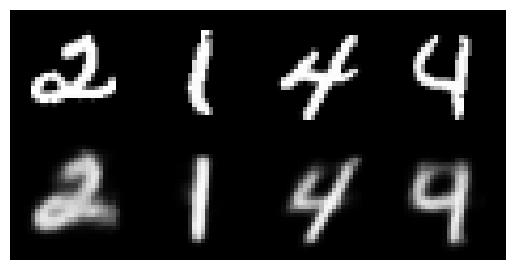

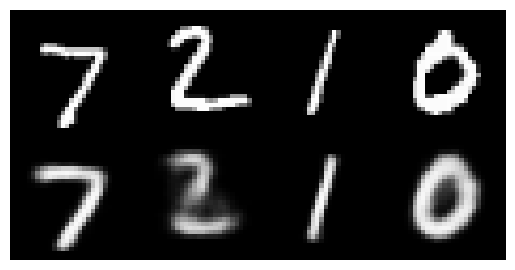

 56%|█████▌    | 28/50 [07:55<06:10, 16.82s/it]


Train loss: 140.59255 |  kl_div: 17.58626 | reconstruction_loss: 123.00629141996664%

Test loss: 141.57192 | kl_div: 17.67534 | reconstruction_loss: 123.8965734167944%



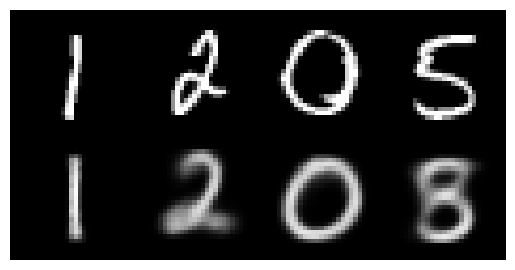

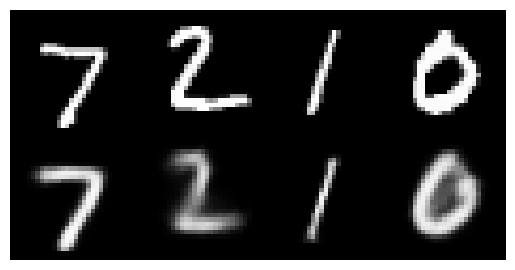

 58%|█████▊    | 29/50 [08:12<05:55, 16.93s/it]


Train loss: 140.78208 |  kl_div: 17.58440 | reconstruction_loss: 123.19767670133221%

Test loss: 142.47839 | kl_div: 17.53474 | reconstruction_loss: 124.94365103033525%



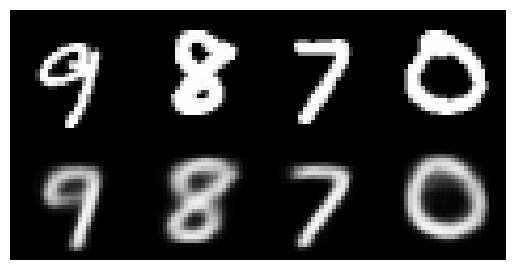

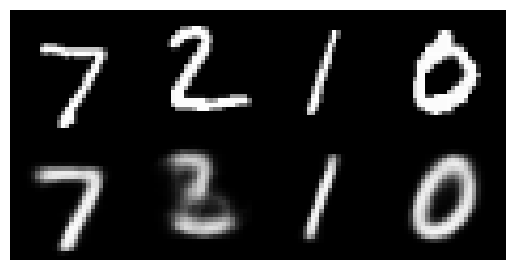

 60%|██████    | 30/50 [08:28<05:36, 16.80s/it]


Train loss: 140.72681 |  kl_div: 17.60097 | reconstruction_loss: 123.12584416241026%

Test loss: 141.54596 | kl_div: 17.75870 | reconstruction_loss: 123.78726292863676%



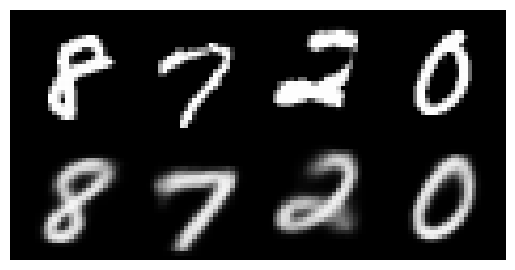

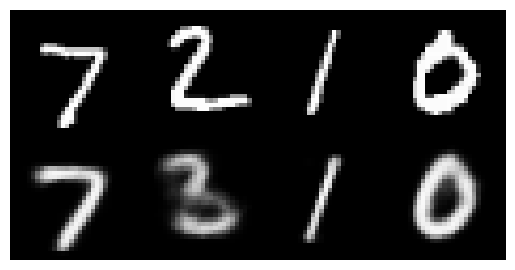

 62%|██████▏   | 31/50 [08:45<05:20, 16.85s/it]


Train loss: 140.59021 |  kl_div: 17.59697 | reconstruction_loss: 122.99323715177427%

Test loss: 141.53368 | kl_div: 17.50745 | reconstruction_loss: 124.02622812005538%



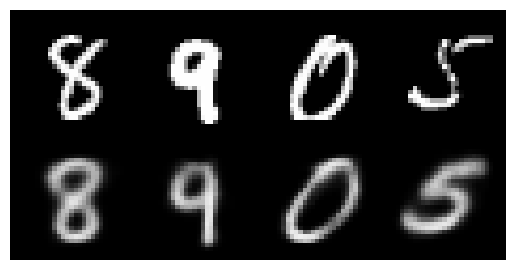

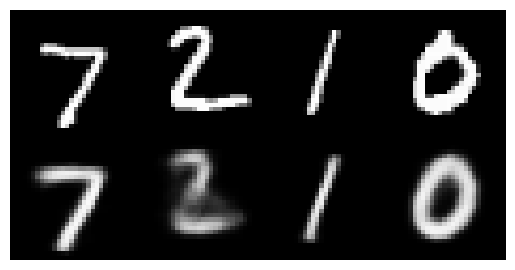

 64%|██████▍   | 32/50 [09:02<05:00, 16.71s/it]


Train loss: 140.33955 |  kl_div: 17.68337 | reconstruction_loss: 122.65617826091709%

Test loss: 140.88270 | kl_div: 17.72571 | reconstruction_loss: 123.15699072729183%



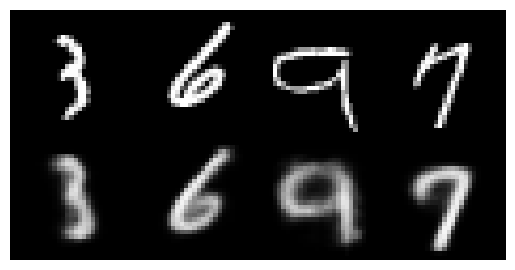

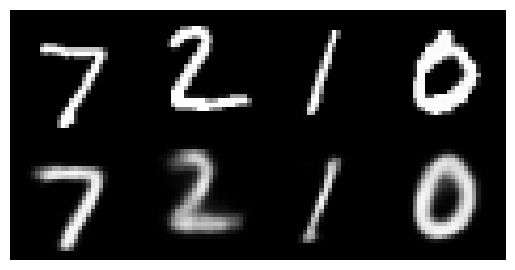

 66%|██████▌   | 33/50 [09:19<04:44, 16.75s/it]


Train loss: 140.29357 |  kl_div: 17.67906 | reconstruction_loss: 122.6145124455759%

Test loss: 141.69492 | kl_div: 17.46175 | reconstruction_loss: 124.23316965223867%



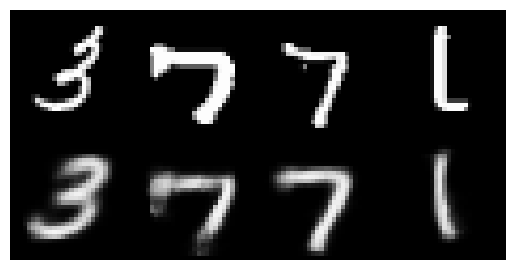

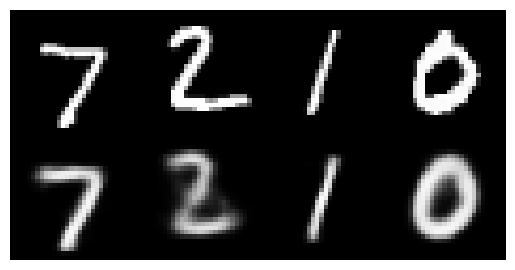

 68%|██████▊   | 34/50 [09:35<04:25, 16.61s/it]


Train loss: 140.25826 |  kl_div: 17.64026 | reconstruction_loss: 122.61800560209035%

Test loss: 140.66158 | kl_div: 17.65418 | reconstruction_loss: 123.0073983880538%



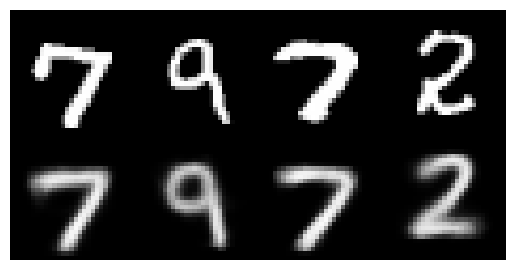

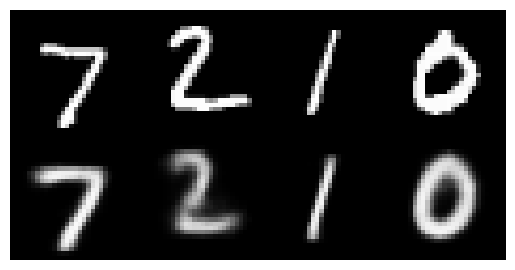

 70%|███████   | 35/50 [09:52<04:10, 16.68s/it]


Train loss: 140.25678 |  kl_div: 17.71955 | reconstruction_loss: 122.53723225868079%

Test loss: 141.09769 | kl_div: 17.80507 | reconstruction_loss: 123.29261683210542%



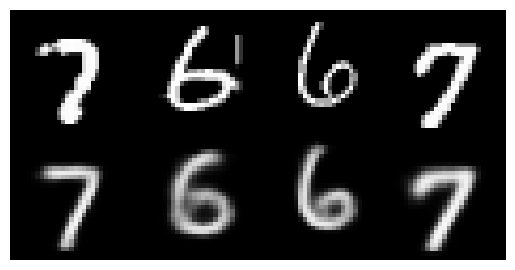

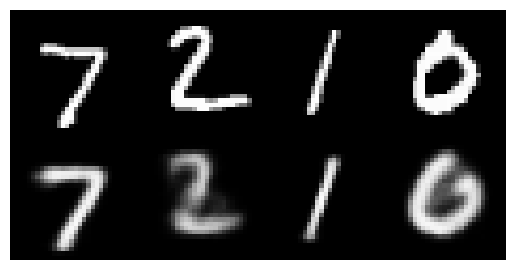

 72%|███████▏  | 36/50 [10:08<03:52, 16.58s/it]


Train loss: 140.13644 |  kl_div: 17.71765 | reconstruction_loss: 122.41878328953725%

Test loss: 141.29956 | kl_div: 17.40838 | reconstruction_loss: 123.89117914513696%



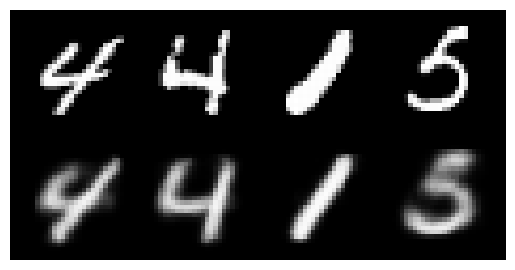

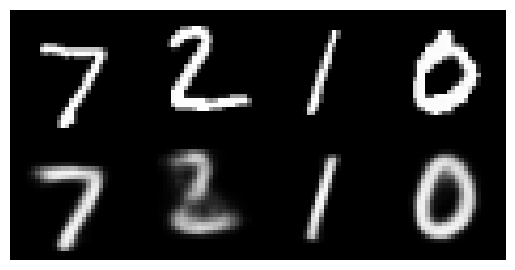

 74%|███████▍  | 37/50 [10:25<03:37, 16.71s/it]


Train loss: 140.18676 |  kl_div: 17.71733 | reconstruction_loss: 122.46943514891016%

Test loss: 141.05472 | kl_div: 17.70148 | reconstruction_loss: 123.35324087022227%



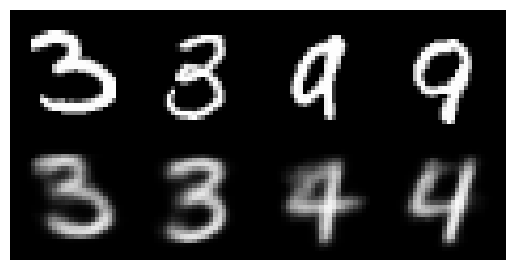

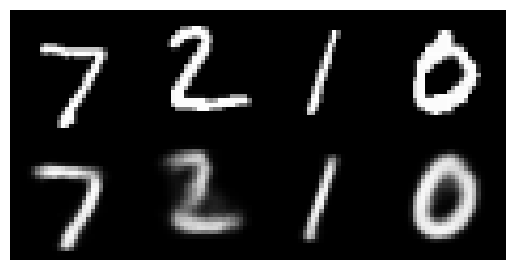

 76%|███████▌  | 38/50 [10:41<03:18, 16.57s/it]


Train loss: 140.18708 |  kl_div: 17.72219 | reconstruction_loss: 122.46489362574336%

Test loss: 140.88585 | kl_div: 17.47385 | reconstruction_loss: 123.41199464435819%



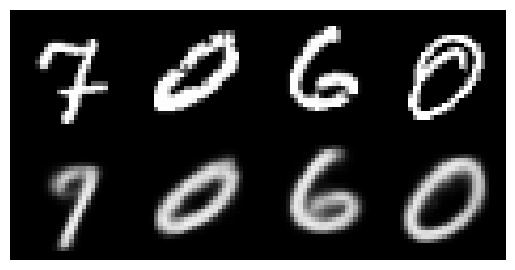

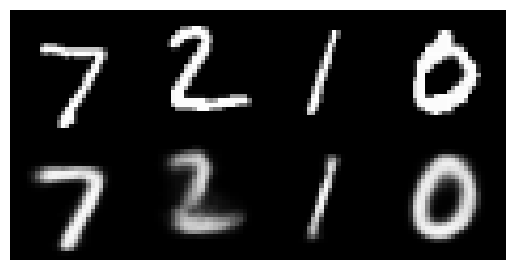

 78%|███████▊  | 39/50 [10:58<03:04, 16.74s/it]


Train loss: 140.28652 |  kl_div: 17.70990 | reconstruction_loss: 122.57662078922492%

Test loss: 140.98095 | kl_div: 17.82487 | reconstruction_loss: 123.15608756149871%



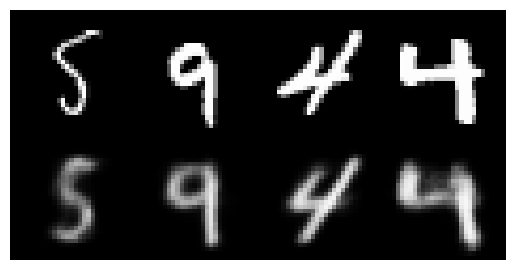

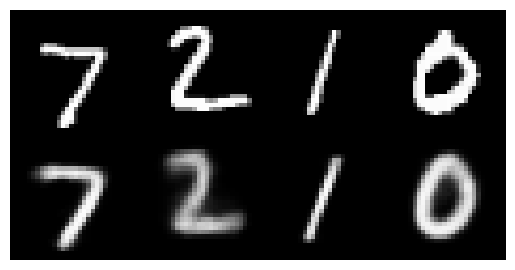

 80%|████████  | 40/50 [11:15<02:45, 16.59s/it]


Train loss: 140.46417 |  kl_div: 17.70446 | reconstruction_loss: 122.75971321154759%

Test loss: 141.13567 | kl_div: 17.54930 | reconstruction_loss: 123.58637015427215%



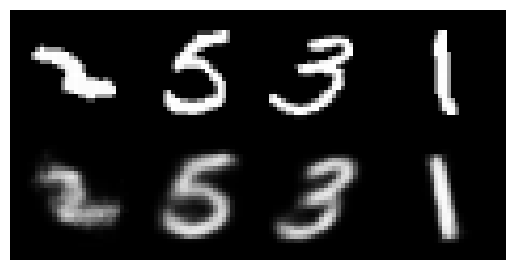

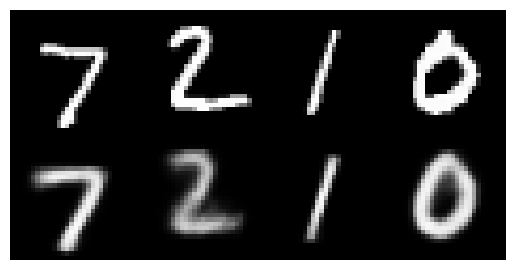

 82%|████████▏ | 41/50 [11:31<02:30, 16.67s/it]


Train loss: 139.88084 |  kl_div: 17.77186 | reconstruction_loss: 122.10898510377798%

Test loss: 140.41819 | kl_div: 17.87214 | reconstruction_loss: 122.54604725898066%



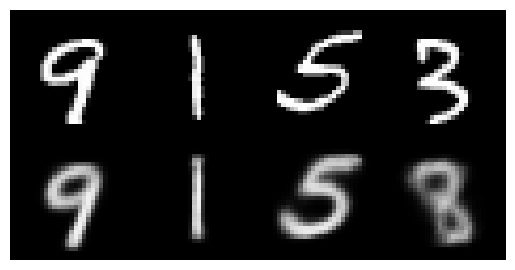

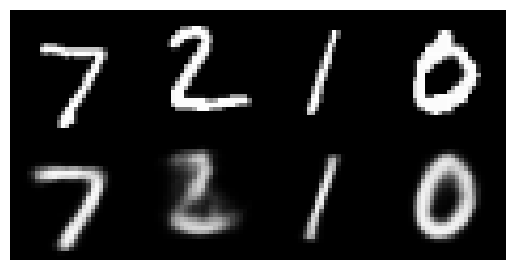

 84%|████████▍ | 42/50 [11:48<02:12, 16.57s/it]


Train loss: 139.97861 |  kl_div: 17.77221 | reconstruction_loss: 122.20639792891708%

Test loss: 140.91070 | kl_div: 17.64884 | reconstruction_loss: 123.26186554341376%



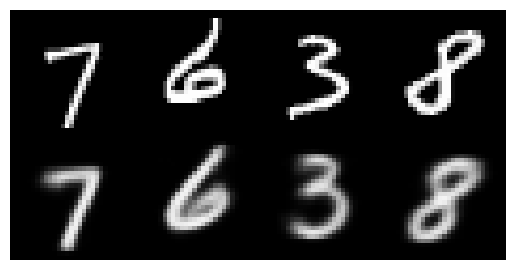

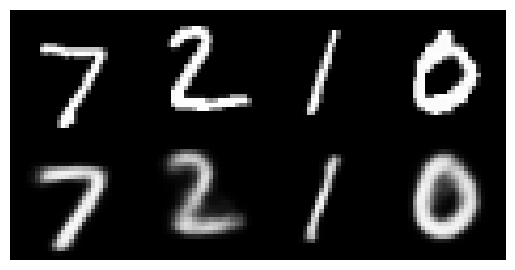

 86%|████████▌ | 43/50 [12:05<01:57, 16.72s/it]


Train loss: 140.11805 |  kl_div: 17.74599 | reconstruction_loss: 122.37205515131514%

Test loss: 141.13320 | kl_div: 17.66760 | reconstruction_loss: 123.46559519707402%



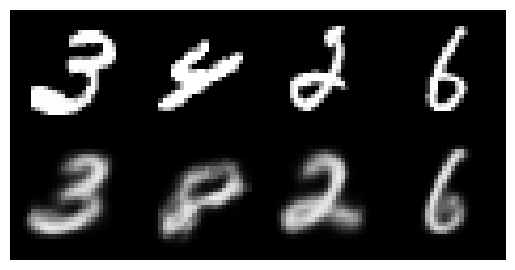

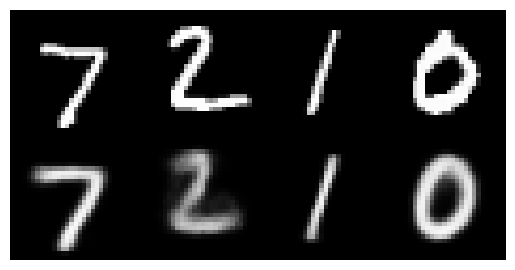

 88%|████████▊ | 44/50 [12:21<01:39, 16.60s/it]


Train loss: 140.22425 |  kl_div: 17.76267 | reconstruction_loss: 122.46158500622585%

Test loss: 141.18247 | kl_div: 17.67102 | reconstruction_loss: 123.5114544252806%



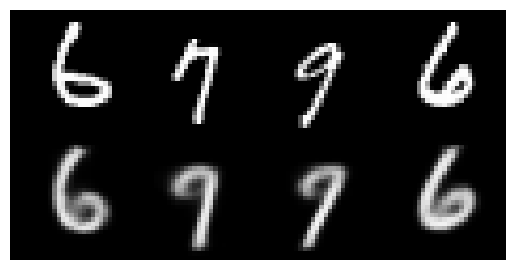

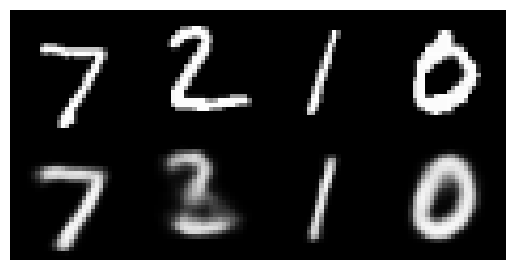

 90%|█████████ | 45/50 [12:38<01:23, 16.72s/it]


Train loss: 140.32232 |  kl_div: 17.76161 | reconstruction_loss: 122.56071237917902%

Test loss: 140.93856 | kl_div: 17.67051 | reconstruction_loss: 123.2680413934249%



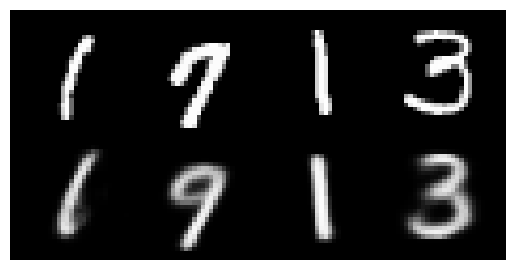

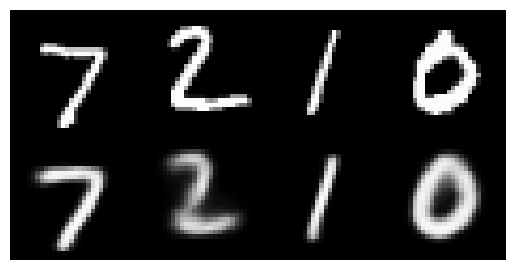

 92%|█████████▏| 46/50 [12:55<01:06, 16.63s/it]


Train loss: 140.14009 |  kl_div: 17.77816 | reconstruction_loss: 122.36192948070925%

Test loss: 140.10287 | kl_div: 17.65878 | reconstruction_loss: 122.44408851333812%



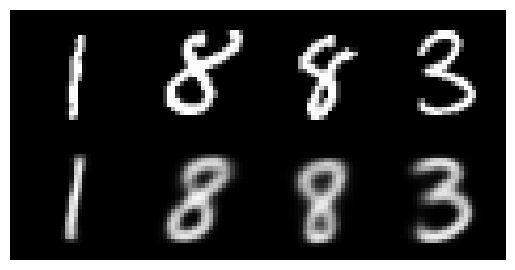

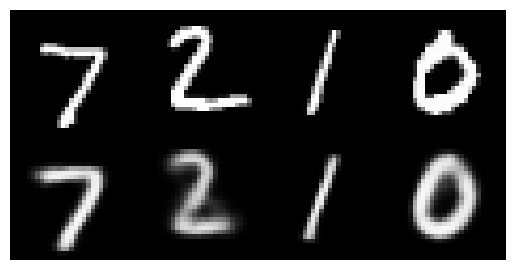

 94%|█████████▍| 47/50 [13:12<00:50, 16.79s/it]


Train loss: 139.92574 |  kl_div: 17.79847 | reconstruction_loss: 122.1272689559058%

Test loss: 140.64109 | kl_div: 17.50991 | reconstruction_loss: 123.13118048559261%



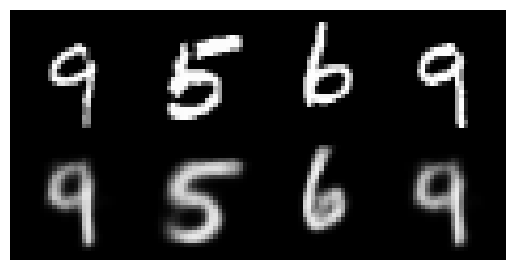

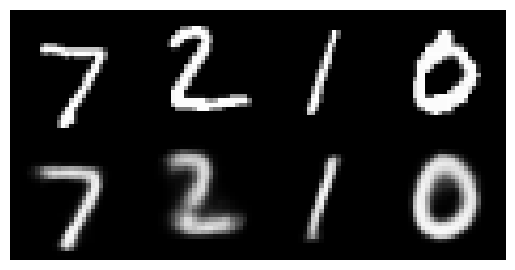

 96%|█████████▌| 48/50 [13:28<00:33, 16.70s/it]


Train loss: 139.91838 |  kl_div: 17.81858 | reconstruction_loss: 122.09979451388946%

Test loss: 140.77653 | kl_div: 17.82534 | reconstruction_loss: 122.95119302484053%



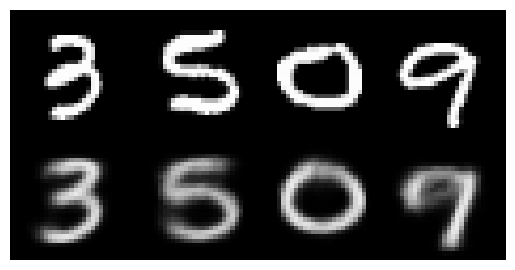

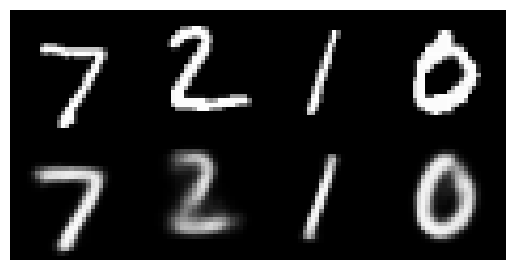

 98%|█████████▊| 49/50 [13:45<00:16, 16.80s/it]


Train loss: 140.05096 |  kl_div: 17.81686 | reconstruction_loss: 122.234099902578%

Test loss: 141.51757 | kl_div: 17.50903 | reconstruction_loss: 124.00854047944274%



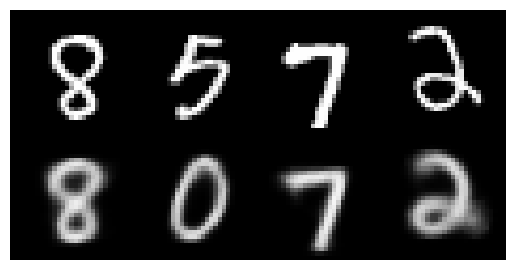

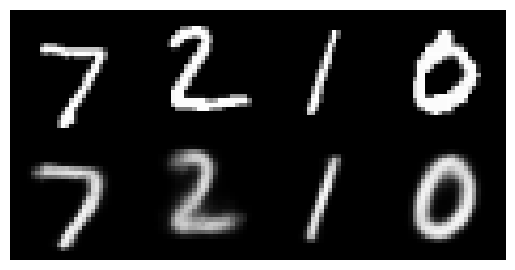

100%|██████████| 50/50 [14:02<00:00, 16.85s/it]


In [26]:
def make_kl_warmup_scheduler(warmup_epochs:int=10 , k:int=1):
    return lambda epoch : (1.0, min(epoch**k/warmup_epochs**k+start, end))

device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 50
#weight_scheduler = make_kl_warmup_scheduler(warmup_epochs=5, k=2)
weight_scheduler = lambda epoch : (1.0, 2.5)
loss_fn = ELBOLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-3)
train_losses, val_losses = train(train_loader, val_loader, 
                                 epochs, optimizer,  model, loss_fn, weight_scheduler, device)

Bluriness and distortions are present in the samples. Greater bluriness and distortion can be observed when we weigh the regularization term (or increase the information bottleneck). This may be because the regularization term forces the encoder to lose some information about the input X (make z more independent of x).

In [37]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML


def plot_graph(loader, model, device, reduction="pca"):
    model.to(device)
    latent_codes = []
    labels = []

    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device),Y.to(device) 
            preds, mu, log_vars = model(X)
            latent_codes.append(mu.cpu().numpy())
            labels.append(Y.cpu().numpy())
    
    latent_codes = np.concatenate(latent_codes)
    labels = np.concatenate(labels)
    
    if reduction == "pca":
        embedded = PCA(n_components=2).fit_transform(latent_codes)
    
    elif reduction == "tsne":
        embedded = TSNE(n_components=2).fit_transform(latent_codes)
    elif reduction == "none":
        assert latent_codes.shape[-1] == 2
        embedded = latent_codes
    else:
        raise Exception
        
    sns.scatterplot(x=embedded[:, 0], y=embedded[:, 1], hue=labels, palette="deep")

def plot_samples(model, N, device):
    model.to(device)
    model.eval()
    latent_codes = torch.randn(N, model.latent_dim).to(device)

    with torch.inference_mode():
        decoded = model.decode(latent_codes).reshape(-1, 28, 28).cpu()

    
    show_images(list(decoded), nrows = int(N**0.5))

def inter(z1, z2, model, device):
    model.to(device)
    model.eval()
    z1, z2 = torch.randn(2, model.latent_dim)

    with torch.inference_mode():
        interpolation = np.linspace(z1.cpu(), z2.cpu(), num=128)
        latent_codes = torch.Tensor(interpolation).to(device)
        decoded = model.decode(latent_codes).reshape(-1, 28, 28).cpu()
    
    fig, ax = plt.subplots()
    ims = [[ax.imshow(im, animated=True)] for im in decoded]
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=1000)
    plt.close(fig)
    return HTML(ani.to_html5_video())


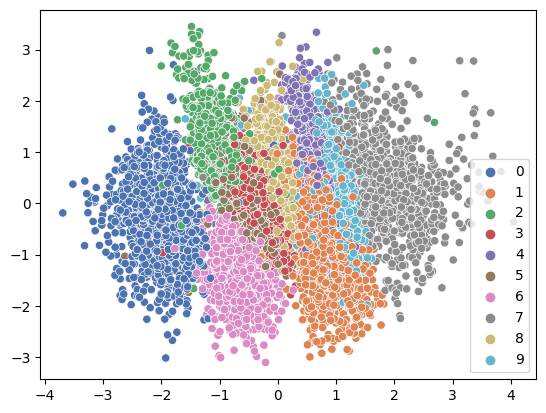

In [49]:
plot_graph(val_loader, model, device, reduction="pca")

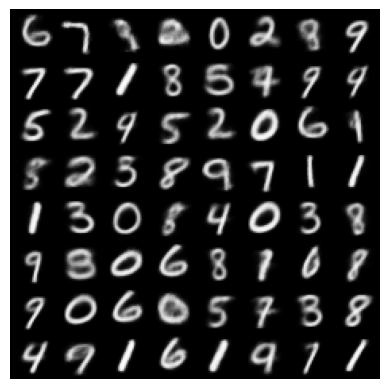

In [39]:
plot_samples(model, N=64, device=device)

In [51]:
z1, z2 = torch.randn(2, model.latent_dim)*5
inter(z1, z2, model, device)

there is a continuous progression between digits (i;e smooth interpolation). the model isn't good at producing 2's and 8's while it is excellent at producing zeros. most generated digits look valid with the addition of some in between digits. samples are difficult to evaluate since there’s no simple way to measure how different these are from the training set, as mentioned in carl doersch's tutorial.

doersch's implementation also used an mlp with relu activation functions. Encoder layers are composed of 784->1000->500->250->30, with a similar structure for the decoder layers. latent dim is chosen to be 30(with my implementation have 32). Like doersch I used cross entropy(binary cross entropy to be exact) and assumes the output distribution to be bernouli. Training difficulty increased for lower latent dimensions probably because not information bottleneck was too large given the complexity of data. for z in range 32 and 64 the model trained well with slight tuning to the weight given to the kl term. His sample outputs are more representative of the training dist with a lot of variation, while my samples are seemingly more generic with a larger number of in between digits. This probably suggests too much weight was given to the regularization term, resulting in a lot of information/variance from original training samples to be lost.